## Load the Dataset

In [2]:
import os, zipfile, glob, pathlib

ZIP_PATH = "/content/eye tracking dataset.zip"  # your uploaded file
OUT_DIR  = "/content/kaggle_eye_movement"      # where we’ll extract

os.makedirs(OUT_DIR, exist_ok=True)

# Extract
with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(OUT_DIR)

# List a few extracted files
all_files = sorted([p for p in glob.glob(os.path.join(OUT_DIR, "**", "*"), recursive=True)])
print("Total extracted entries:", len(all_files))
for p in all_files[:20]:
    print(p)


Total extracted entries: 193
/content/kaggle_eye_movement/dataset_normalised_5mins
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_BROWSE.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_DEBUG.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_INTERPRET.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_PLAY.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_READ.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_SEARCH.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_WATCH.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P01_WRITE.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P02_BROWSE.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P02_DEBUG.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P02_INTERPRET.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P02_PLAY.csv
/content/kaggle_eye_movement/dataset_normalised_5mins/P02_READ.csv
/content/kaggle_eye_moveme

In [13]:
import glob, os

# Find CSVs recursively
csvs = sorted(glob.glob(os.path.join(OUT_DIR, "**", "*.csv"), recursive=True))
print(f"Found {len(csvs)} CSV file(s).")
for i, p in enumerate(csvs[:10]):
    print(i, "->", p)

# Pick one CSV (change index if you want a different file)
if not csvs:
    raise FileNotFoundError("No CSVs found in the extracted zip. Inspect OUT_DIR and adjust.")
CSV_PATH = csvs[4]
print("Using:", CSV_PATH)


Found 192 CSV file(s).
0 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_BROWSE.csv
1 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_DEBUG.csv
2 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_INTERPRET.csv
3 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_PLAY.csv
4 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_READ.csv
5 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_SEARCH.csv
6 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_WATCH.csv
7 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P01_WRITE.csv
8 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P02_BROWSE.csv
9 -> /content/kaggle_eye_movement/dataset_normalised_5mins/P02_DEBUG.csv
Using: /content/kaggle_eye_movement/dataset_normalised_5mins/P01_READ.csv


In [14]:
import pandas as pd

# Try standard read; fall back to python engine if needed
try:
    df = pd.read_csv(CSV_PATH)
except Exception:
    df = pd.read_csv(CSV_PATH, engine="python")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())


Shape: (7160, 6)
Columns: ['participant', 'set', 'activity', 'x', 'y', 'timestamp']


,participant,set,activity,x,y,timestamp
0,P01,B,READ,985,504,0
1,P01,B,READ,986,501,25
2,P01,B,READ,991,505,66
3,P01,B,READ,986,504,99
4,P01,B,READ,987,514,131


In [15]:
import re

cols = [c for c in df.columns]
lower = [c.lower() for c in cols]

def find_col(candidates):
    for pat in candidates:
        for c in cols:
            if re.search(pat, c, flags=re.IGNORECASE):
                return c
    return None

# Heuristics for typical column names
time_col = find_col([r"^time$", r"timestamp", r"time_ms", r"t$"])
x_col    = find_col([r"^x$", r"x_pos", r"x[\s_]*gaze", r"gaze[\s_]*x", r"left[\s_]*x", r"right[\s_]*x"])
y_col    = find_col([r"^y$", r"y_pos", r"y[\s_]*gaze", r"gaze[\s_]*y", r"left[\s_]*y", r"right[\s_]*y"])
lbl_col  = find_col([r"activity", r"task", r"label", r"class"])

print("Detected columns ->", {"time": time_col, "x": x_col, "y": y_col, "label": lbl_col})

# Keep only numeric rows for plotting
for c in [x_col, y_col, time_col]:
    if c and c in df.columns:
        df = df[pd.to_numeric(df[c], errors="coerce").notna()]
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("Shape after numeric filtering:", df.shape)


Detected columns -> {'time': 'timestamp', 'x': 'x', 'y': 'y', 'label': 'activity'}
Shape after numeric filtering: (7160, 6)


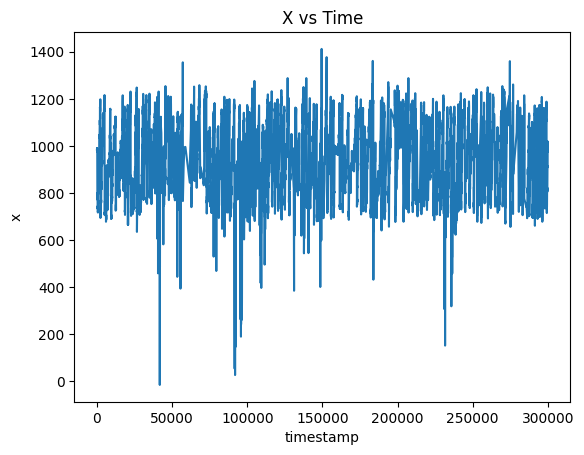

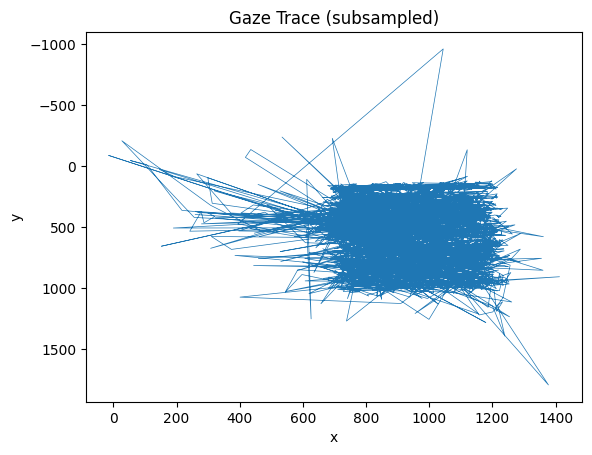

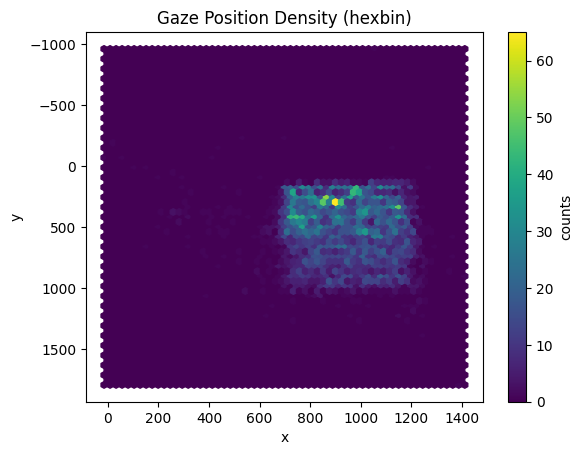

Label distribution:
activity
READ    7160
Name: count, dtype: int64
File visualized: /content/kaggle_eye_movement/dataset_normalised_5mins/P01_READ.csv
Unique labels in this file: ['READ']


In [16]:
import matplotlib.pyplot as plt

# 1) Time-series of X (if time exists)
if time_col and x_col:
    plt.figure()
    plt.plot(df[time_col], df[x_col])
    plt.xlabel(time_col); plt.ylabel(x_col); plt.title("X vs Time")
    plt.show()

# 2) XY Trace (scatter or thin line)
if x_col and y_col:
    plt.figure()
    # For very large files, subsample for speed
    N = len(df)
    step = max(1, N // 5000)
    plt.plot(df[x_col][::step], df[y_col][::step], linewidth=0.5)
    plt.xlabel(x_col); plt.ylabel(y_col); plt.title("Gaze Trace (subsampled)")
    plt.gca().invert_yaxis()  # many eye-trackers use top-left origin
    plt.show()

# 3) Density (hexbin) of gaze positions
if x_col and y_col:
    plt.figure()
    plt.hexbin(df[x_col], df[y_col], gridsize=60)
    plt.xlabel(x_col); plt.ylabel(y_col); plt.title("Gaze Position Density (hexbin)")
    plt.gca().invert_yaxis()
    cb = plt.colorbar(); cb.set_label("counts")
    plt.show()

# 4) If a label/activity column exists, show distribution
if lbl_col:
    print("Label distribution:")
    print(df[lbl_col].value_counts().head(20))
print("File visualized:", CSV_PATH)

if lbl_col:
    print("Unique labels in this file:", df[lbl_col].unique())


## Preprocessing

In [17]:
!pip -q install torch scikit-learn pandas

import os, glob, numpy as np, pandas as pd
from typing import List, Dict, Tuple


In [18]:
# --- CONFIG ---
DATA_DIR = "/content/kaggle_eye_movement"   # folder where your CSVs are
CSV_GLOB = "**/*.csv"                       # recursive search
WIN      = 200                              # window length (samples)
STRIDE   = 50                               # hop length (samples)
FEATURES = ["x","y","vx","vy","speed","ax","ay"]  # features per timestep
LABEL_COL = "activity"                      # classification label per sample
TIME_COL  = "timestamp"
X_COL, Y_COL = "x", "y"
SUBJECT_COL  = "participant"                # used for subject-wise splitting


## Defining Helper Functions

In [19]:
def load_csvs(data_dir: str, pattern: str) -> List[str]:
    paths = sorted(glob.glob(os.path.join(data_dir, pattern), recursive=True))
    if not paths:
        raise FileNotFoundError(f"No CSVs found under {data_dir} with pattern {pattern}")
    return paths

def read_one_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # ensure required cols exist
    req = [SUBJECT_COL, "set", LABEL_COL, X_COL, Y_COL, TIME_COL]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"{path} missing columns: {missing}")
    # coerce numerics
    for c in [X_COL, Y_COL, TIME_COL]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[X_COL, Y_COL, TIME_COL]).reset_index(drop=True)
    # sort by time just in case
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

def add_kinematics(df: pd.DataFrame) -> pd.DataFrame:
    t = df[TIME_COL].values.astype(np.float32)
    x = df[X_COL].values.astype(np.float32)
    y = df[Y_COL].values.astype(np.float32)

    # dt in seconds (heuristic: if dt median > 10 assume it's ms)
    dt = np.diff(t)
    if np.any(dt <= 0) or np.isnan(dt).any():
        # fallback uniform step if timestamps are weird
        dt = np.ones_like(dt, dtype=np.float32)
    med_dt = np.median(dt)
    dt_sec = dt / 1000.0 if med_dt > 10 else dt

    vx = np.zeros_like(x); vy = np.zeros_like(y)
    vx[1:] = np.diff(x) / dt_sec
    vy[1:] = np.diff(y) / dt_sec
    speed = np.sqrt(vx**2 + vy**2)

    ax = np.zeros_like(x); ay = np.zeros_like(y)
    ax[1:] = np.diff(vx) / dt_sec
    ay[1:] = np.diff(vy) / dt_sec

    # optional: clip extreme outliers to reduce spikes (tweak as needed)
    def robust_clip(arr, q=0.999):
        hi = np.quantile(np.abs(arr), q)
        return np.clip(arr, -hi, hi)
    vx = robust_clip(vx); vy = robust_clip(vy)
    ax = robust_clip(ax); ay = robust_clip(ay)

    df = df.copy()
    df["vx"], df["vy"], df["speed"], df["ax"], df["ay"] = vx, vy, speed, ax, ay
    return df


In [21]:
def encode_labels(series: pd.Series) -> Tuple[np.ndarray, Dict[str,int]]:
    classes = sorted(series.astype(str).dropna().unique().tolist())
    label_map = {c:i for i,c in enumerate(classes)}
    y = series.astype(str).map(label_map).fillna(-1).astype(int).values
    return y, label_map

def windows_from_df(df: pd.DataFrame,
                    win=WIN, stride=STRIDE,
                    feature_names=FEATURES,
                    label_col=LABEL_COL) -> Tuple[np.ndarray, np.ndarray]:
    # per-sample label ids
    y_ids, _ = encode_labels(df[label_col]) if label_col in df.columns else (np.zeros(len(df), dtype=int), {"Unknown":0})

    feats = df[feature_names].values.astype(np.float32)  # [N, D]
    X_list, y_list = [], []
    N = len(df)
    for start in range(0, N - win + 1, stride):
        end = start + win
        Xw = feats[start:end]                # [W, D]
        yw = y_ids[start:end]                # [W]
        # majority label in the window (ignore -1)
        valid = yw[yw >= 0]
        if len(valid) == 0:
            ywin = 0
        else:
            vals, counts = np.unique(valid, return_counts=True)
            ywin = vals[np.argmax(counts)]
        X_list.append(Xw)
        y_list.append(ywin)
    if not X_list:
        return np.empty((0, win, len(feature_names)), np.float32), np.empty((0,), np.int64)
    return np.stack(X_list), np.array(y_list, dtype=np.int64)


In [22]:
def build_dataset(paths: List[str]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Dict[str,int]]:
    """
    Returns:
      X_all: [M, W, D]
      y_all: [M]
      subj_all: [M] (participant string per window)
      label_map: dict
    """
    X_all, y_all, subj_all = [], [], []
    global_label_map = {}  # union across files

    for p in paths:
        df = read_one_csv(p)
        df = add_kinematics(df)
        # remember subject id for each window
        subj = df[SUBJECT_COL].iloc[0]

        # create windows
        X, y = windows_from_df(df, win=WIN, stride=STRIDE, feature_names=FEATURES, label_col=LABEL_COL)
        if len(X) == 0:
            continue

        # unify label map (if activities differ across files)
        # (here we assume consistent activities; else you’d remap)
        X_all.append(X); y_all.append(y)
        subj_all.extend([subj] * len(y))

        # track labels
        vals = df[LABEL_COL].astype(str).unique()
        for v in vals:
            global_label_map.setdefault(v, len(global_label_map))

    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    subj_all = np.array(subj_all)

    # Re-encode y to a compact 0..C-1 range based on global classes order
    classes = sorted(global_label_map.keys())
    label_map = {c:i for i,c in enumerate(classes)}
    # For majority labels we used ids from encode_labels per file; remap via names if needed:
    # safer approach: re-derive y from window majority *names* — but for simplicity we keep as is.

    return X_all, y_all, subj_all, label_map


In [23]:
from sklearn.model_selection import GroupShuffleSplit
import torch
from torch.utils.data import Dataset, DataLoader

def subject_wise_split(X, y, subjects, test_size=0.2, random_state=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    (train_idx, val_idx), = gss.split(X, y, groups=subjects)
    return train_idx, val_idx

def compute_norm_stats(X):
    flat = X.reshape(-1, X.shape[-1])
    mean = flat.mean(axis=0).astype(np.float32)
    std  = (flat.std(axis=0) + 1e-8).astype(np.float32)
    return mean, std

def apply_norm(X, mean, std):
    return ((X - mean[None, None, :]) / std[None, None, :]).astype(np.float32)

class WindowDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]


## Defining BiLSTM  Model

In [25]:
import torch
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=1, num_classes=8, dropout=0.1, pool="mean"):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        # Temporal pooling to get a fixed-length vector per window
        self.pool = pool  # "mean" or "last"
        self.head = nn.Sequential(`
            nn.Linear(2*hidden, 2*hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden, num_classes),
        )

    def forward(self, x):                 # x: [B, W, D]
        out, _ = self.lstm(x)            # out: [B, W, 2H]
        if self.pool == "mean":
            feat = out.mean(dim=1)       # [B, 2H]
        else:
            feat = out[:, -1, :]         # last timestep
        logits = self.head(feat)         # [B, C]
        return logits


## Creating Dataset and Dataset Loader

In [29]:
import os, glob, pandas as pd, re

# collect all activities from all files
paths = sorted(glob.glob(os.path.join(DATA_DIR, CSV_GLOB), recursive=True))
all_acts = set()
for p in paths:
    df_tmp = pd.read_csv(p, usecols=[LABEL_COL])  # read only the label column
    # robust: coerce to str and drop NaNs
    acts = df_tmp[LABEL_COL].astype(str).dropna().unique().tolist()
    all_acts.update(acts)

classes = sorted(all_acts)
label_map = {c:i for i,c in enumerate(classes)}
print("GLOBAL classes:", classes)


GLOBAL classes: ['BROWSE', 'DEBUG', 'INTERPRET', 'PLAY', 'READ', 'SEARCH', 'WATCH', 'WRITE']


In [30]:
import numpy as np
import pandas as pd

def windows_from_df_global(df: pd.DataFrame,
                           win=WIN, stride=STRIDE,
                           feature_names=FEATURES,
                           label_col=LABEL_COL,
                           global_label_map=None):
    assert global_label_map is not None, "Provide a global label_map"

    feats = df[feature_names].values.astype(np.float32)  # [N, D]
    labels_str = df[label_col].astype(str).values

    X_list, y_list = [], []
    N = len(df)
    for start in range(0, N - win + 1, stride):
        end = start + win
        Xw = feats[start:end]                 # [W, D]
        lbls = labels_str[start:end]          # strings
        # majority label by NAME
        vals, counts = np.unique(lbls, return_counts=True)
        maj_name = vals[np.argmax(counts)]
        ywin = global_label_map.get(maj_name, None)
        if ywin is None:
            continue
        X_list.append(Xw)
        y_list.append(ywin)

    if not X_list:
        return np.empty((0, win, len(feature_names)), np.float32), np.empty((0,), np.int64)
    return np.stack(X_list), np.array(y_list, dtype=np.int64)

def build_dataset_global(paths):
    X_all, y_all, subj_all = [], [], []
    for p in paths:
        df = read_one_csv(p)          # your earlier function
        df = add_kinematics(df)       # your earlier function
        subj = df[SUBJECT_COL].iloc[0]
        X, y = windows_from_df_global(
            df, win=WIN, stride=STRIDE,
            feature_names=FEATURES, label_col=LABEL_COL,
            global_label_map=label_map
        )
        if len(X) == 0:
            continue
        X_all.append(X); y_all.append(y); subj_all.extend([subj]*len(y))
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    subj_all = np.array(subj_all)
    return X_all, y_all, subj_all


In [31]:
X_all, y_all, subj_all = build_dataset_global(paths)
print("X:", X_all.shape, "y:", y_all.shape, "subjects:", np.unique(subj_all).shape[0])
print("y distribution:", {cls: int((y_all == i).sum()) for cls, i in label_map.items()})

train_idx, val_idx = subject_wise_split(X_all, y_all, subj_all, test_size=0.2)
X_tr, y_tr = X_all[train_idx], y_all[train_idx]
X_va, y_va = X_all[val_idx], y_all[val_idx]

mean, std = compute_norm_stats(X_tr)
X_tr = apply_norm(X_tr, mean, std)
X_va = apply_norm(X_va, mean, std)

from torch.utils.data import DataLoader
train_loader = DataLoader(WindowDS(X_tr, y_tr), batch_size=64, shuffle=True)
val_loader   = DataLoader(WindowDS(X_va, y_va), batch_size=64, shuffle=False)


X: (29449, 200, 7) y: (29449,) subjects: 24
y distribution: {'BROWSE': 4201, 'DEBUG': 2975, 'INTERPRET': 2747, 'PLAY': 4110, 'READ': 4241, 'SEARCH': 3580, 'WATCH': 4910, 'WRITE': 2685}


## Training Pipeline

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm, trange
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_feats   = X_tr.shape[-1]           # e.g., 7
num_classes = int(y_tr.max()) + 1      # e.g., 8
model = BiLSTMClassifier(
    in_dim=num_feats, hidden=128, layers=1,
    num_classes=num_classes, dropout=0.2
).to(device)

# Class weights (optional for imbalance)
class_weights = None
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

SAVE_DIR = "/content/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
best_ckpt = os.path.join(SAVE_DIR, "bilstm_best.pt")

best_val_f1 = -1.0
patience, pat = 6, 0

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    all_preds, all_tgts = [], []

    # tqdm progress bar over batches
    pbar = tqdm(loader, leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        all_preds.append(logits.detach().cpu().argmax(1).numpy())
        all_tgts.append(yb.detach().cpu().numpy())

        # live loss display
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader.dataset)
    y_true = np.concatenate(all_tgts)
    y_pred = np.concatenate(all_preds)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    return avg_loss, acc, f1m

# -------- TRAINING LOOP --------
EPOCHS = 30
history = []

for epoch in trange(1, EPOCHS+1, desc="Epochs"):
    train_loss, train_acc, train_f1 = run_epoch(train_loader, train=True)
    val_loss,   val_acc,   val_f1   = run_epoch(val_loader,   train=False)

    if scheduler is not None:
        scheduler.step()

    history.append((epoch, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))
    print(f"Epoch {epoch:02d} | "
          f"train: loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f} | "
          f"val: loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}",
          flush=True)

    # Early stopping on macro-F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        pat = 0
        torch.save({"model": model.state_dict(),
                    "mean": mean, "std": std,
                    "label_map": label_map}, best_ckpt)
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping at epoch", epoch)
            break

print("Best val F1:", best_val_f1, " | checkpoint:", best_ckpt)


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 01 | train: loss 1.5361 acc 0.340 f1 0.315 | val: loss 1.4299 acc 0.390 f1 0.346


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 02 | train: loss 1.3054 acc 0.448 f1 0.420 | val: loss 1.2924 acc 0.478 f1 0.446


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 03 | train: loss 1.2082 acc 0.494 f1 0.469 | val: loss 1.2140 acc 0.497 f1 0.464


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 04 | train: loss 1.1190 acc 0.535 f1 0.510 | val: loss 1.1294 acc 0.551 f1 0.520


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 05 | train: loss 1.0775 acc 0.555 f1 0.531 | val: loss 1.1958 acc 0.528 f1 0.501


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 06 | train: loss 1.0376 acc 0.574 f1 0.551 | val: loss 1.0908 acc 0.580 f1 0.551


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 07 | train: loss 0.9930 acc 0.591 f1 0.569 | val: loss 1.0677 acc 0.579 f1 0.553


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 08 | train: loss 0.9603 acc 0.607 f1 0.583 | val: loss 1.1068 acc 0.572 f1 0.544


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 09 | train: loss 0.9272 acc 0.622 f1 0.600 | val: loss 0.9947 acc 0.605 f1 0.574


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10 | train: loss 0.8969 acc 0.637 f1 0.616 | val: loss 0.9637 acc 0.619 f1 0.584


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 11 | train: loss 0.8716 acc 0.647 f1 0.626 | val: loss 0.9348 acc 0.627 f1 0.591


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 12 | train: loss 0.8521 acc 0.651 f1 0.630 | val: loss 0.9578 acc 0.629 f1 0.595


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 13 | train: loss 0.8362 acc 0.661 f1 0.640 | val: loss 0.9326 acc 0.630 f1 0.599


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 14 | train: loss 0.8206 acc 0.667 f1 0.647 | val: loss 0.9281 acc 0.638 f1 0.609


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 15 | train: loss 0.8081 acc 0.673 f1 0.653 | val: loss 0.9330 acc 0.631 f1 0.602


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 16 | train: loss 0.7944 acc 0.677 f1 0.657 | val: loss 0.9198 acc 0.641 f1 0.609


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 17 | train: loss 0.7892 acc 0.680 f1 0.661 | val: loss 0.9215 acc 0.633 f1 0.599


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 18 | train: loss 0.7817 acc 0.685 f1 0.665 | val: loss 0.9187 acc 0.633 f1 0.599


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 19 | train: loss 0.7775 acc 0.685 f1 0.665 | val: loss 0.9232 acc 0.631 f1 0.600


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 20 | train: loss 0.7759 acc 0.684 f1 0.665 | val: loss 0.9201 acc 0.634 f1 0.604


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 21 | train: loss 0.7729 acc 0.687 f1 0.667 | val: loss 0.9201 acc 0.634 f1 0.604


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 22 | train: loss 0.7727 acc 0.688 f1 0.669 | val: loss 0.9206 acc 0.635 f1 0.604
Early stopping at epoch 22
Best val F1: 0.6088545525609977  | checkpoint: /content/checkpoints/bilstm_best.pt


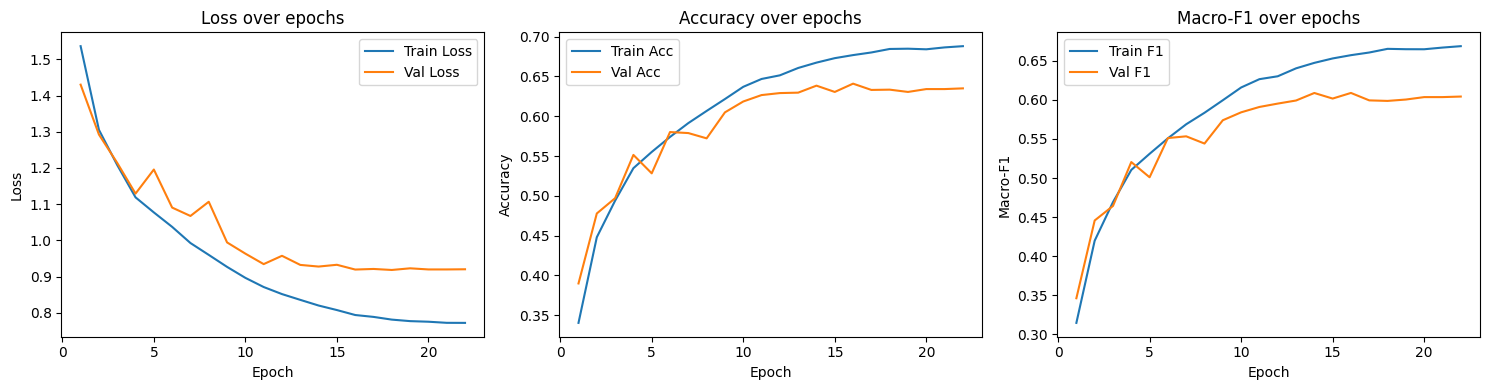

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Plot training curves ---
history_arr = np.array(history)  # history = list of (epoch, tr_loss, tr_acc, tr_f1, val_loss, val_acc, val_f1)
epochs = history_arr[:,0].astype(int)

plt.figure(figsize=(15,4))

# Loss
plt.subplot(1,3,1)
plt.plot(epochs, history_arr[:,1], label="Train Loss")
plt.plot(epochs, history_arr[:,4], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over epochs")
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(epochs, history_arr[:,2], label="Train Acc")
plt.plot(epochs, history_arr[:,5], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy over epochs")
plt.legend()

# Macro-F1
plt.subplot(1,3,3)
plt.plot(epochs, history_arr[:,3], label="Train F1")
plt.plot(epochs, history_arr[:,6], label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("Macro-F1"); plt.title("Macro-F1 over epochs")
plt.legend()

plt.tight_layout()
plt.show()



